In [28]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi
import swarms
import pread as pds

In [29]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [30]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
data = pds.Pread('data', 'Z002', 'pltlum_M318Z002.csv') 

In [31]:
Mmoon = 7.35e22
Mjup = 1.898e27
Rjup = 7.1492e7
AU = 1.496e11
Mearth = 5.972e24
pc = 3.086e16
Msun = 1.989e30
Lsun = 3.828e26

In [32]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_sampler(mean=2., std=1.):
    Mstar = None
    Lstar = None
    Tstar = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            break
    return Mstar, Lstar, Tstar, sample

def distance_sampler(mean=30., std=10.):
    return random.normal(loc=mean, scale=std)*pc

def draw_planet():
    Mmin = 15 # Mearth (Nep)
    Mmax = 13*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 0.5
    Npts = 1000
    alpha = -0.86
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None, None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = 10# AU
        amax = 200 # AU
        a = loguniform(amin, amax)
        return a*AU, ms[idx]*Mearth 
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler():
    y = uniform(0, 1)
    return inverse_cdf(y)

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

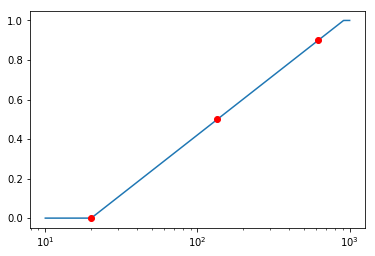

In [33]:
domain = np.logspace(1, 3, 500)
f = cdf(domain)
fig, ax = plt.subplots()
ax.plot(domain, f)
ax.plot(20, 0, 'ro')
ax.plot(135, 0.5, 'ro')
ax.plot(620, 0.9, 'ro')
ax.set_xscale('log')

In [34]:
N = 500

Mstar_list = np.zeros(N)
Lstar_list = np.zeros(N)
Tstar_list = np.zeros(N)
s_type_list = np.zeros(N)
d_list = np.zeros(N)
a_pl_list = np.zeros(N)
Mpl_list = np.zeros(N)
age_list = np.zeros(N)

for i in range(N):
    Mstar, Lstar, Tstar, s_type = star_sampler()
    Mstar_list[i] = Mstar; Lstar_list[i] = Lstar; Tstar_list[i] = Tstar; s_type_list[i] = s_type
    d_list[i] = distance_sampler()
    a_pl, Mpl = draw_planet()
    a_pl_list[i] = a_pl; Mpl_list[i] = Mpl
    age_list[i] = age_sampler()*1e6

In [35]:
def sample(Mstar, Lstar, Tstar, dpl, apl, Mpl, age):
    if apl == None:
        return None
    
    Dc = loguniform(1e5, 1e6) # m
    Mtot = loguniform(0.2, 2)*Mearth#loguniform(1e-4, 1)*Mearth
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.5) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000)
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4/np.pi
    alpha= 1./1.2
    
    swarm = swarms.CollSwarm(Mtot, Dt, Dmax, Lstar, Mstar, Mpl, apl, R_pl=None, eta=eta, Nstr=Nstr, d_pl=dpl,
                            rho=rho, fQ=fQ, f_vrel=f_vrel, correction=True, alpha=alpha, Dmin_min=1.25)

    swarm.updateSwarm(age)
    swarm_contrast = contrast_scat(swarm.computeAtot(), g, Q, apl)
    
    lamb = 1.65e-6
    B_nu = swarm.computeBmu(np.array([lamb]), Tstar)
    F_star = Fstar(Lstar, B_nu, Tstar, apl)
    
    # Planet Emissions
    index = data.find_time_index(age)
    if (index > -1):
        T_plt = lum_to_temp(data.lumin[index], data.radii[index])
        B_nu_plt = swarm.computeBmu(np.array([lamb]), T_plt)
        F_plt = Fstar(data.lumin[index], B_nu_plt, T_plt, apl)
        F_scat = Fscat(F_star, data.radii[index], g, Q, apl)
        #F_scat = contrast_scat(pi*data.radii[index]**2, g, Q, apl)
    else:
        F_scat = None; F_plt = None
    
    return swarm_contrast, F_plt / F_star, F_scat / F_star

In [36]:
CR_swarm_list = np.zeros(N); CR_plt_thermal = np.zeros(N); CR_plt_scat = np.zeros(N)
for i in range(N):
    CR_swarm_list[i], CR_plt_thermal[i], CR_plt_scat[i] = sample(Mstar_list[i], Lstar_list[i], Tstar_list[i], 
                                                                 d_list[i], a_pl_list[i], Mpl_list[i], age_list[i])
    d_list[i] = d_list[i] / pc
    a_pl_list[i] = a_pl_list[i] / AU

c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


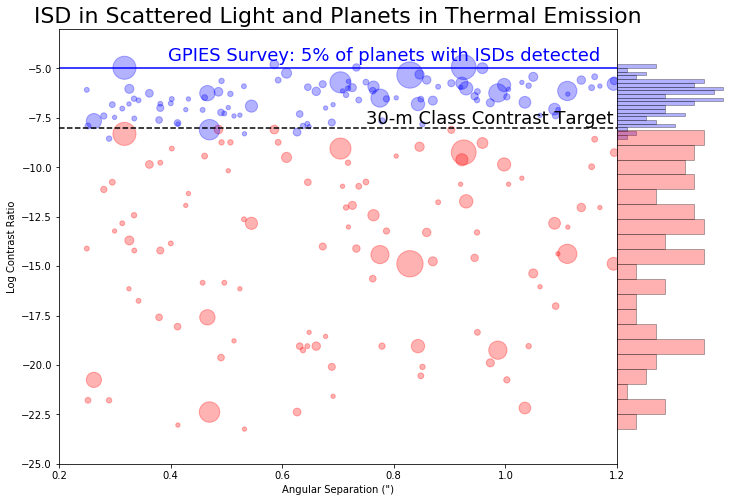

In [37]:
mask = (~np.isnan(CR_swarm_list)) & (a_pl_list/d_list > 0.2) & (a_pl_list/d_list < 1.2)
mask2 = (~np.isnan(CR_plt_thermal)) & (a_pl_list/d_list > 0.2) & (a_pl_list/d_list < 1.2)
cm = plt.cm.get_cmap('RdYlBu')

contrast = np.ones(1000)*1.e-5
contrastsep = np.linspace(0, 1.2, 1000)

sep = a_pl_list[mask]/d_list[mask]
sep2 = a_pl_list[mask2]/d_list[mask2]
logCR = np.log10(CR_swarm_list[mask])
logCR2 = np.log10(CR_plt_thermal[mask2])
Mpltcut = Mpl_list[mask]

idxs = np.searchsorted(contrastsep, sep)
detectable = np.log10(np.array(contrast)[idxs]) < logCR

#print(CR_plt_thermal)

fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
#axarr[0].scatter(sep2[detectable2], logCR2[detectable2], c='r', s=400*Mplt2cut/Mearth/318)
#axarr[0].scatter(sep2[~detectable2], logCR2[~detectable2], c='r', s=400*Mplt2cut/Mearth/318, alpha=0.3)
axarr[0].scatter(sep2, logCR2, c='r', s=400*Mpltcut/Mearth/318, alpha=0.3)
axarr[0].scatter(sep, logCR, c='b', s=400*Mpltcut/Mearth/318, alpha=0.3)
axarr[0].plot(contrastsep, np.log10(contrast), 'b-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-25, -3])
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
axarr[0].set_title('ISD in Scattered Light and Planets in Thermal Emission', fontsize=22)
axarr[0].text(0.395, -4.6, "GPIES Survey: {0:.0f}% of planets with ISDs detected".format(detectable.sum()/len(sep)*100), color='b', fontsize=18)
axarr[0].text(0.75, -7.8, "30-m Class Contrast Target", color='k', fontsize=18)


plt.subplots_adjust(wspace=0)
axarr[1].set_axis_off()

vals, bins, patches = axarr[1].hist(np.log10(CR_swarm_list[mask]), orientation='horizontal', bins=20, facecolor='b', ec='k', alpha=0.3)
vals, bins, patches = axarr[1].hist(np.log10(CR_plt_thermal[mask]), orientation='horizontal', bins=20, facecolor='r', ec='k', alpha=0.3)

c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


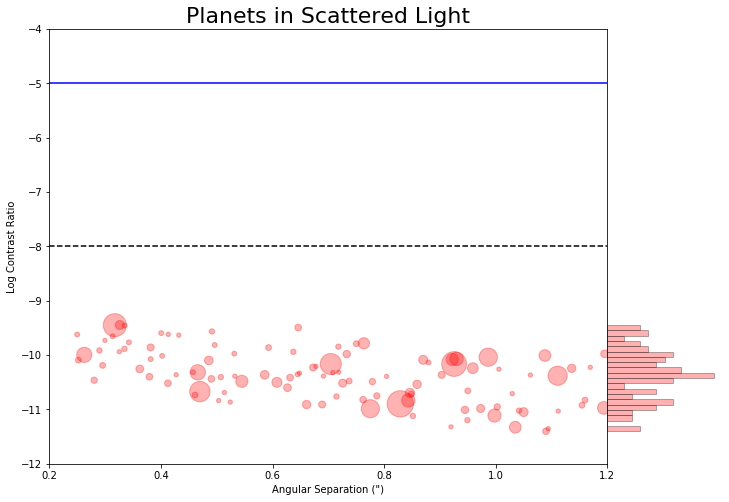

In [39]:
mask3 = (~np.isnan(CR_plt_scat)) & (a_pl_list/d_list > 0.2) & (a_pl_list/d_list < 1.2)

sep3 = a_pl_list[mask3]/d_list[mask3]
logCR3 = np.log10(CR_plt_scat[mask3])

fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
axarr[0].scatter(sep3, logCR3, c='r', s=400*Mpltcut/Mearth/318, alpha=0.3)
axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-12, -4])
axarr[0].plot(contrastsep, np.log10(contrast), 'b-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
axarr[0].set_title('Planets in Scattered Light', fontsize=22)


plt.subplots_adjust(wspace=0)
axarr[1].set_axis_off()

vals, bins, patches = axarr[1].hist(np.log10(CR_plt_scat[mask3]), orientation='horizontal', bins=20, facecolor='r', ec='k', alpha=0.3)